# Generacja trójkątnych siatek obliczeniowych w Julii

Jan Starczewski  
nr. albumu 291105  
Informatyka Stosowana

## Wstęp

Celem projektu jest generacja trójkątnej siatki obliczeniowej bazując na alogrytmie [DistMesh](http://persson.berkeley.edu/distmesh/). Program generujący siatkę został napisany w języku programowania Julia. Algorytm DistMesh, pozwalający mim innym na generację trójkątnych siatek obliczeniowych na płaszczyźnie, jest powszechnie znanym rozwiązaniem w dziedzinie metody numerycznych. Napisany pierwotnie w `MatLabie`, doczekał się reimplementacji w innych językach programowania, nadających się do analizy numerycznej. Zważając na fakt, że nawet w Julii istnieją już sprawdzone implementacje DistMesh, samodzielna próba odtworzenia algorytmu jest zadaniem pozwalającym na dokładne poznanie i zrozumienie szczegółów procesu generacji siatek obliczeniowych. 


## Implementacja algorytmu

Poniższy projekt przeprowadza przez proces generacji początkowej siatki obliczeniowej, tłumacząc działanie algorytmu oraz poszczególne operacje niezbędne do generacji. W pracy zostały użyte narzędzia, niewykorzystane w innych dostępnych implementacjach algorytmu `DistMesh`, takich jak [Julia DistMesh](https://github.com/JuliaGeometry/DistMesh.jl). Zabieg ten wymusił częściowe odejście od wzoru algorytmu napisanego w programie `MatLab`, przez [Per-Olof Persson'a](http://persson.berkeley.edu/) oraz [Gilberta Strang](https://en.wikipedia.org/wiki/Gilbert_Strang) w pracy  [A SIMPLE MESH GENERATOR IN MATLAB](http://persson.berkeley.edu/distmesh/persson04mesh.pdf?fbclid=IwAR3gaXZdSvYMVLpicOw4N2PTribIAAJlESwrTKzCdw3C6ePZM4ill5ulE0g). Wyniki otrzymywane w kolejnych krokach programu były porównane z wynikami jakie zwracała wzorcowa implementacja.

## Generacja początkowej siatki obliczeniowej
Funkcja generująca siatkę w rozpatrywanym przykładzie posiada następujący nagłówek
```Julia
function generate(fd, fh, bbox, h0)
```
Parametry:
* `fd` oznaczona funkcja odległości
* `fh` oczekiwana długość boku, zdefiniowana jako funkcja zwracająca stałą wartość
* `bbox` Boundry Box definiujący obszar wewnątrz którego narysujemy kształt
* `h0` odległość początkową między punktami

## Oznaczona funkcja odległości
Podstawowym problemem podczas tworzenia algorytmu było przyjęcie konwencji w jaki sposób należy zdefiniować kształt wewnątrz którego narysowana zostanie siatka obliczeniowa. Został on rozwiązany za sprawą <em>oznaczonych funkcji odległości d(x,y)</em>, które <strong>przyjmują wartości ujemne wewnątrz rozpatrywanego kształtu</strong>. Oznaczona funkcja odległości zwraca odległość do najbliższej granicy dla wybranego punktu. 

W pracy będziemy starali się pokryć siatką obliczeniową wnętrze okręgu zdefiniowanego przez następujące równanie.  $ {x^{2}}+{y^{2}}=1 $  
Zapisujemy oznaczoną funkcję odległości dla tego kształtu, jako funkcję w języki Julia. Funkcja jako argument przyjmuje wartość `p` będącą dwuelementową macierzą reprezentującą punkt `[x y]`. 

In [1]:
function fd(p)
    return sqrt(sum(p.^2))-1
end

fd (generic function with 1 method)

## Długość boku siatki dla danego punktu
Następnym krokiem jest zdefiniowanie funkcji, która określa długość boku siatki dla danych wartości `x`i `y`. W przykładzie została użyta funkcja, zwracająca zawsze stałą wartość.

In [2]:
function fh(x,y)
    return 0.2
end

fh (generic function with 1 method)

## Meshgrid
Algorytm rozpoczyna pracę od utworzenie siatki wypełnionej punktami. W Matlabie jest to zrealizowane w następujący sposób:
```Matlab
   [x,y]=meshgrid(bbox(1,1):h0:bbox(2,1),bbox(1,2):h0*sqrt(3)/2:bbox(2,2));
```
W Julii nie istnieje funkcja `meshgrid` o takiej samej funkcjonalności, z tego powodu jesteśmy zmuszeni napisać ją sami. Funkcja przyjmuje jako parametry dwa wektory o tym samym typie danych, zdefiniowanym przez typ generyczny `T`. Funkcja tworzy macierz punktów będących położeniem początkowym.

In [3]:
function meshgrid(vx::AbstractVector{T}, vy::AbstractVector{T}) where {T}
    m, n = length(vy), length(vx)
    gx = reshape(repeat(vx, inner = m, outer = 1), m, n)
    gy = reshape(repeat(vy, inner = 1, outer = n), m, n)
    return gx, gy
end

meshgrid (generic function with 1 method)

Funkcja `repeat` powiela elementy macierzy, tak jak widać to na poniższym przykładzie. Oprócz macierzy, w której następuje powielanie elementów, wymagany jest również sposób powielenia, przekazany w postaci `named parameters`.

In [4]:
a = [1; 2]

2-element Array{Int64,1}:
 1
 2

In [5]:
repeat(a, inner = 2)

4-element Array{Int64,1}:
 1
 1
 2
 2

Funkcja `reshape` tworzy macierz wypełnioną elementami danego wektora, o wymiarach przekazanych jako kolejne parametry. W przypadku funkcji `meshgrid`, macierz ma wymiary odpowiadające długościom przekazanych wektorów punktów `x` i `y`. 

## Początkowe rozłożenie punktów

Do funkcji `meshgrid` przekazujemy punkty początkowe w postaci wektorów. Zostały one wyznaczone na podstawie `BoundryBox'a`, z odległością `h0` między punktami na osi OX i odległością `h1` na osi OY.

In [6]:
bbox = [-1 -1; 1 1]

2×2 Array{Int64,2}:
 -1  -1
  1   1

In [7]:
h0 = 0.2

0.2

In [8]:
h1 = h0 * sqrt(3)/2

0.17320508075688773

Definiujemy wektor `v1` reprezentujący kolejno współrzędne `x` punktów początkowych.

In [9]:
v1 = bbox[1, 1]:h0:bbox[2, 1]

-1.0:0.2:1.0

Definiujemy wektor `v2` reprezentujący kolejno współrzędne `y` punktów początkowych.

In [10]:
v2 = bbox[1, 2]:h1:bbox[2, 2]

-1.0:0.17320508075688773:0.9052558883257651

W celu uzyskania efektu kratownicy, powstałym położeniu początkowym, co drugi punkt na osi OX przesuwamy połowę wartości `h0`. 

In [11]:
x, y = meshgrid(v1, v2)
x[2:2:end, :] = x[2:2:end, :] .+ h0 / 2

6×11 Array{Float64,2}:
 -0.9  -0.7  -0.5  -0.3  -0.1  0.1  0.3  0.5  0.7  0.9  1.1
 -0.9  -0.7  -0.5  -0.3  -0.1  0.1  0.3  0.5  0.7  0.9  1.1
 -0.9  -0.7  -0.5  -0.3  -0.1  0.1  0.3  0.5  0.7  0.9  1.1
 -0.9  -0.7  -0.5  -0.3  -0.1  0.1  0.3  0.5  0.7  0.9  1.1
 -0.9  -0.7  -0.5  -0.3  -0.1  0.1  0.3  0.5  0.7  0.9  1.1
 -0.9  -0.7  -0.5  -0.3  -0.1  0.1  0.3  0.5  0.7  0.9  1.1

Z użyciem biblioteki `Gadfly` wizualizujemy punkty rysując wykres punktowy.

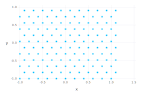

In [12]:
using Gadfly;
p = [x[:] y[:]]
points_plot = Gadfly.plot(x=p[:,1], y=p[:,2])

### Odrzucenie puntków poza rozpatrywaną przestrzenią
Punkty poza rozpatrywana przestrzenią zostają usunięte na podstawie wartości zwróconej przez oznaczoną funkcję odległości, która dla nich przyjmuje wartość większą, bądź równą 0. Z uwagi na dokładność obliczeń numerycznych, wartości funkcji są obarczone tolerancja określoną przez stałą  `geps = .001*h0`.

In [13]:
geps = 0.001*h0

0.0002

Poniższa operacja w środowisku `MatLab` odrzuca punkty poza obszarem, gdzie `varargin{:}` oznacza dodatkowe parametry, które może przyjąć funkcja `fd`,  co pozwala większą kontrolę nad pracą algorytmu.
```Matlab
p=p(feval(fd,p,varargin{:})<geps,:); 
```
Dodatkowe parametry nie są rozpatrywane w `Julii`. Struktura `valid_p` zawiera punkty wewnątrz kształtu. Odrzucenie jest zaimplementowane przez iterację po rzędach macierzy `p` i rzędów nie spełniających warunku. Każdy rząd jest złączczany wzdłuż długości.

In [14]:
valid_p = [vcat(point_row) for point_row in eachrow(p) if fd(point_row) < geps]

88-element Array{Array{Float64,1},1}:
 [-0.9, -0.1339745962155614]                
 [-0.9, 0.21243556529821417]                
 [-0.7000000000000001, -0.48038475772933675]
 [-0.8, -0.3071796769724491]                
 [-0.7000000000000001, -0.1339745962155614] 
 [-0.8, 0.039230484541326494]               
 [-0.7000000000000001, 0.21243556529821417] 
 [-0.8, 0.38564064605510184]                
 [-0.7000000000000001, 0.5588457268119895]  
 [-0.5, -0.8267949192431123]                
 [-0.6, -0.6535898384862245]                
 [-0.5, -0.48038475772933675]               
 [-0.6, -0.3071796769724491]                
 ⋮                                          
 [0.6, -0.3071796769724491]                 
 [0.7, -0.1339745962155614]                 
 [0.6, 0.039230484541326494]                
 [0.7, 0.21243556529821417]                 
 [0.6, 0.38564064605510184]                 
 [0.7, 0.5588457268119895]                  
 [0.6, 0.7320508075688772]                  
 [0.8, -0.3071796

Wektor zawierający mniejsze dwuelementowe wektory współrzędnych zostaje zamieniony na macierz.
```Julia
valid_p_m = transpose(reshape(vcat(valid_p...), 2, length(valid_p)))
```
Z uwagi na dość sporą złożoność powyższej instrukcji, zostaje ona rozłożona na części pierwsze.  
Rozbijamy wektor wektorów na pojedynczy wektor o zawierający wszystkie współrzędne.

In [15]:
valid_p_spread = vcat(valid_p...)

176-element Array{Float64,1}:
 -0.9                 
 -0.1339745962155614  
 -0.9                 
  0.21243556529821417 
 -0.7000000000000001  
 -0.48038475772933675 
 -0.8                 
 -0.3071796769724491  
 -0.7000000000000001  
 -0.1339745962155614  
 -0.8                 
  0.039230484541326494
 -0.7000000000000001  
  ⋮                   
  0.6                 
  0.7320508075688772  
  0.8                 
 -0.3071796769724491  
  0.9                 
 -0.1339745962155614  
  0.8                 
  0.039230484541326494
  0.9                 
  0.21243556529821417 
  0.8                 
  0.38564064605510184 

Wynikiem operacji jest wektor spłaszczony do pierwszego wymiaru zawierający naprzemiennie  wartości `x`, `y` poszczególnych punktów. Wektor zmieniamy na macierz o dwóch rzędach i ilości kolumn równej ilości punktów.

In [16]:
valid_p_spread_m = reshape(valid_p_spread, 2, length(valid_p))

2×88 Array{Float64,2}:
 -0.9       -0.9       -0.7       -0.8      …  0.8        0.9       0.8     
 -0.133975   0.212436  -0.480385  -0.30718     0.0392305  0.212436  0.385641

Macierz transponujemy uzyskując strukturę, w której kolejne rzędy reprezentują współrzędne punktów `x` i `y`.

In [17]:
valid_points = transpose(valid_p_spread_m)

88×2 LinearAlgebra.Transpose{Float64,Array{Float64,2}}:
 -0.9  -0.133975 
 -0.9   0.212436 
 -0.7  -0.480385 
 -0.8  -0.30718  
 -0.7  -0.133975 
 -0.8   0.0392305
 -0.7   0.212436 
 -0.8   0.385641 
 -0.7   0.558846 
 -0.5  -0.826795 
 -0.6  -0.65359  
 -0.5  -0.480385 
 -0.6  -0.30718  
  ⋮              
  0.6  -0.30718  
  0.7  -0.133975 
  0.6   0.0392305
  0.7   0.212436 
  0.6   0.385641 
  0.7   0.558846 
  0.6   0.732051 
  0.8  -0.30718  
  0.9  -0.133975 
  0.8   0.0392305
  0.9   0.212436 
  0.8   0.385641 

### Prawdopodobnieństwo zatrzymania punktu
Punkty dla których wartość funkcji h(x,y) jest proporcjonalna do 1/h(x,y)^2 można odrzucić. Zapewnia to szybszą zbieżność dla siatek o różnych długościach krawędzi.
W Matlabie odpowiada za to poniższy blok.
```Matlab
r0=1./feval(fh,p,varargin{:}).^2;
p=[pfix; p(rand(size(p,1),1)<r0./max(r0),:)];
```
Poniżej implementacja w `Julii`.

In [18]:
r0 = 1 ./ fh(valid_points[:,1], valid_points[:,2]).^2

24.999999999999996

Określamy `r0_max`

In [19]:
r0_max = r0./max(r0)

1.0

In [20]:
valid_points_r = [vcat(point_row) for point_row in eachrow(valid_points) if (rand(Float64, size(valid_points)))[1] < r0_max ]

88-element Array{Array{Float64,1},1}:
 [-0.9, -0.1339745962155614]                
 [-0.9, 0.21243556529821417]                
 [-0.7000000000000001, -0.48038475772933675]
 [-0.8, -0.3071796769724491]                
 [-0.7000000000000001, -0.1339745962155614] 
 [-0.8, 0.039230484541326494]               
 [-0.7000000000000001, 0.21243556529821417] 
 [-0.8, 0.38564064605510184]                
 [-0.7000000000000001, 0.5588457268119895]  
 [-0.5, -0.8267949192431123]                
 [-0.6, -0.6535898384862245]                
 [-0.5, -0.48038475772933675]               
 [-0.6, -0.3071796769724491]                
 ⋮                                          
 [0.6, -0.3071796769724491]                 
 [0.7, -0.1339745962155614]                 
 [0.6, 0.039230484541326494]                
 [0.7, 0.21243556529821417]                 
 [0.6, 0.38564064605510184]                 
 [0.7, 0.5588457268119895]                  
 [0.6, 0.7320508075688772]                  
 [0.8, -0.3071796

Wektor wektorów zamieniamy na macierz, analogicznie do wcześniejszego przykładu.

In [21]:
points = transpose(reshape(vcat(valid_points_r...), 2, length(valid_points_r)))

88×2 LinearAlgebra.Transpose{Float64,Array{Float64,2}}:
 -0.9  -0.133975 
 -0.9   0.212436 
 -0.7  -0.480385 
 -0.8  -0.30718  
 -0.7  -0.133975 
 -0.8   0.0392305
 -0.7   0.212436 
 -0.8   0.385641 
 -0.7   0.558846 
 -0.5  -0.826795 
 -0.6  -0.65359  
 -0.5  -0.480385 
 -0.6  -0.30718  
  ⋮              
  0.6  -0.30718  
  0.7  -0.133975 
  0.6   0.0392305
  0.7   0.212436 
  0.6   0.385641 
  0.7   0.558846 
  0.6   0.732051 
  0.8  -0.30718  
  0.9  -0.133975 
  0.8   0.0392305
  0.9   0.212436 
  0.8   0.385641 

W przykładzie, żadne punkty nie zostały odrzucone ze względu na stałą wartość funkcji `fh`.

In [22]:
N = size(points,1)

88

### Wizualizacja punktów początkowych
Wykres punktowy ułożenia początkowego.

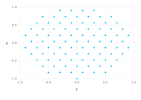

In [23]:
r_points_plot = Gadfly.plot(x=points[:,1], y=points[:,2])

## Pętla główna alogrytmu
Optymalizacja położenia punktów znajduje się w pętli głównej algorytmu, posiadającej następującą strukturę.
```Julia
pold = Inf
while true
# Triangulacja    
# Przesuwanie punktów
# Kryteria zatrzymania    
end
```
Zmienna `pold` przechowuje strukturę punktów po każdej retriangulacji. 
Triangulacja [Delone](https://pl.wikipedia.org/wiki/Triangulacja_Delone) jest przeprowadzana z wykorzystaniem biblioteki [VoronoiDelaunay.jl](https://github.com/JuliaGeometry/VoronoiDelaunay.jl) będącej natywnym rozwiazaniem zaimplementowanym całkowicie w języku `Julia`. Biblioteka posiada inny interfejs niż jej odpowiednik funkcjonalny w środowisku `Matlab`. Generuje to problemy związane z przeprowadzaniem podobnych operacji na strukturze siatki w późniejszych etapach implementacji algorytmu. 

### Triangulacja
Biblioteka  [VoronoiDelaunay.jl](https://github.com/JuliaGeometry/VoronoiDelaunay.jl) operuje na wartościach z przedziału `1.0` do `2.0` z tego powodu rozpatrywane dane ulegają przeskalowaniu. Po przeskalowaniu, punkty należy przemapować z prymitywnych wartości `x` i `y` na strukturę dopuszczalną relatywną wartość o jaką mogą przesunąć się punkty przed triangulacją.

In [24]:
ttol = 0.1
pold = Inf

Inf

### Wynik cząstkowy triangulacji
W procesie iteracji pętli głównej, triangulacja zachodzi gdy spełniony jest poniższy warunek, sprawdzający czy efekt triangulacji będzie widoczny. 

In [25]:
if(maximum(sqrt.(sum((points.-pold).^2, dims = 2)/h0))>ttol)
    # Triangulacja
end    

Triangulacji przeprowadzamy, wciągając bibliotekę i tworząc obiekt reprezentujacy tesselację.

In [26]:
using VoronoiDelaunay
tess = DelaunayTessellation();

Punkty są poddawane transformacjom w celu oddania ich rozłożenia na płaszczyźnie, obsługiwanej przez bibliotekę.

In [27]:
#Skala
scale = abs(1/(bbox[1] - bbox[2]))

0.5

In [28]:
#Przesunięcie OX
transx = sqrt((-(0-bbox[1]*scale)-1)^2)

1.5

In [29]:
#Przesunięcie OY
transy = sqrt((-(0-bbox[1,2]*scale)-1)^2)

1.5

Wartości prymitywne zostają przekształcone na strukturę danych `Point2D`.

In [30]:
points2d = map(el -> Point(el[1]*scale+transx, el[2]*scale+transy), eachrow(points))

88-element Array{Point2D,1}:
 Point2D(1.05, 1.4330127018922192)
 Point2D(1.05, 1.606217782649107) 
 Point2D(1.15, 1.2598076211353315)
 Point2D(1.1, 1.3464101615137753) 
 Point2D(1.15, 1.4330127018922192)
 Point2D(1.1, 1.5196152422706632) 
 Point2D(1.15, 1.606217782649107) 
 Point2D(1.1, 1.692820323027551)  
 Point2D(1.15, 1.7794228634059948)
 Point2D(1.25, 1.0866025403784438)
 Point2D(1.2, 1.1732050807568877) 
 Point2D(1.25, 1.2598076211353315)
 Point2D(1.2, 1.3464101615137753) 
 ⋮                                
 Point2D(1.8, 1.3464101615137753) 
 Point2D(1.85, 1.4330127018922192)
 Point2D(1.8, 1.5196152422706632) 
 Point2D(1.85, 1.606217782649107) 
 Point2D(1.8, 1.692820323027551)  
 Point2D(1.85, 1.7794228634059948)
 Point2D(1.8, 1.8660254037844386) 
 Point2D(1.9, 1.3464101615137753) 
 Point2D(1.95, 1.4330127018922192)
 Point2D(1.9, 1.5196152422706632) 
 Point2D(1.95, 1.606217782649107) 
 Point2D(1.9, 1.692820323027551)  

Punkty zostają dodane do obiektu teselacji. 

In [31]:
push!(tess, points2d)

Wizualizacja siatkii w przedziale od `1.0` do `2.0`.

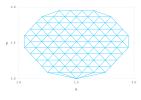

In [32]:
x, y = getplotxy(delaunayedges(tess))
mesh_plot = Gadfly.plot(x=x, y=y, Geom.path)
#Gadfly.draw(PDF("Mesh.pdf"), mesh_plot)

# Wnioski

Próba odtworzenia algorytmu `DistMesh` z użyciem języka programowania `Julia` zakończyła się 
połowicznym sukcesem. Problematyczne okazały się operacje na punktach i krawędziach z użyciem interfejsu wystawionego przez bibliotekę [VoronoiDelaunay.jl](https://github.com/JuliaGeometry/VoronoiDelaunay.jl). W `MatLabie` do tych obliczeń wykorzystuje się informacje o wierzchołkach siatki. Operacje te są wymagane do poprawnego przesunięcia punktów na podstawie zaaplikowanych wektorów siły. Opisana w pracy implementacja algorytmu pozwala na wygenerowanie siatki początkowej, której punkty są ulegają przesunięciu w kolejnych fazach algorytmu. Struktura otrzymanej siatki jest identyczna do wzoru wygenerowanego w `Matlabie`, co świadczy o poprawności wykonywanych transformacji i obliczeń. 